In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
def load_pic(path):
    
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [3]:
picnum = 0 #for saving pictures
#Read image
fig = plt.figure(figsize = (20,10))
tetris = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/tetris.png')
#plt.imshow(tetris)
#plt.show()
path = 'F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/outputs/P6/'
#I'm saving this picture just because I included it at the beginning of the video, no exception 
cv2.imwrite(path+'tetris%d.png'%picnum, cv2.cvtColor(tetris, cv2.COLOR_RGB2BGR))
frameSize = (tetris.shape[1], tetris.shape[0])
out = cv2.VideoWriter(path+'output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 2, frameSize)
out.write(cv2.cvtColor(tetris, cv2.COLOR_RGB2BGR))

<Figure size 1440x720 with 0 Axes>

In [4]:
# These are gonna be necessary across the code
width = tetris.shape[1]//12
height = tetris.shape[0]//22
w = width//2
h = height//2

In [5]:
#gonna be creating the state matrix by checking where in the picture is colored
cells = np.zeros((22,12))
for i in range(22):
    for j in range(12):
        if any(tetris[h+i*height, w+j*width]!=0):
            cells[i,j]=1

In [6]:
#making sure the walls don't get recognized as blocks for what I'm about to do
cells[0,:],cells[:,0],cells[-1,:],cells[:,-1] = -1,-1,-1,-1

In [7]:
#reading the block pictures
i = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/I.png')
l = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/L.png')
t = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/T.png')
o = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/O.png')
s = load_pic('F://Uni/992/Digital Image Processing/Homeworks/DIP_HW1/inputs/P6/S.png')

In [8]:
#I'm turning all the white parts to black, because I'm gonna be using the pictures themselves in the game
i[np.all(i==[255,255,255],axis=-1)] =[0,0,0]
l[np.all(l==[255,255,255],axis=-1)] =[0,0,0] 
t[np.all(t==[255,255,255],axis=-1)] =[0,0,0]
o[np.all(o==[255,255,255],axis=-1)] =[0,0,0]
s[np.all(s==[255,255,255],axis=-1)] =[0,0,0]

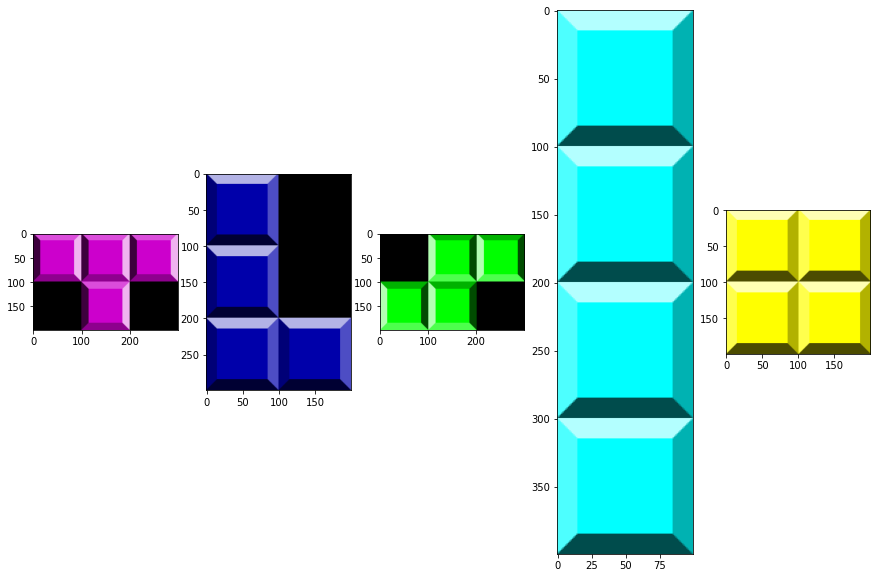

In [9]:
#Just getting to know the blocks
fig, ax = plt.subplots(1,5,figsize=(15,10))
ax[0].imshow(t)
ax[1].imshow(l)
ax[2].imshow(s)
ax[3].imshow(i)
ax[4].imshow(o)
plt.show()

In [10]:
#Yeap the blocks are gonna be rotating
def rotate(img, way):
    #well we can't have the same shape sizes as before, can we?
    #It's a dot product with rotation matrix, I just implemented it this way :D
    shape0 = abs(round((img.shape[0]*(np.cos(way*(np.pi/2))))+(img.shape[1]*(-np.sin(way*(np.pi/2))))))
    shape1 = abs(round((img.shape[0]*(np.sin(way*(np.pi/2))))+(img.shape[1]*(np.cos(way*(np.pi/2))))))
    imgrotate = np.zeros((shape0,shape1,3))
    #gotta rotate so the color values of the new coordinates need to be set to the calculated coordinates
    for m in range(imgrotate.shape[0]):
        for n in range(imgrotate.shape[1]):
            m2 = (m*round(np.cos(way*(np.pi/2))))+(n*round(-np.sin(way*(np.pi/2))))
            n2 = (m*round(np.sin(way*(np.pi/2))))+(n*round(np.cos(way*(np.pi/2))))
            imgrotate[m,n] = img[m2,n2]
    imgrotate = imgrotate.astype('uint8')
    return imgrotate

In [11]:
#using this for creating the new state and the new tetris picture
def next_state(current, letter, way, px, py):
    if letter=='i':
        img = i
    elif letter=='l':
        img = l
    elif letter=='t':
        img = t
    elif letter=='o':
        img = o
    else:
        img = s
    if way!=0:
        img = rotate(img, way)
    
    tetristate = tetris.copy()
    #needed np.max for when a block has sat upon another block so it doesn't make that part black
    #and needed to use the block shape to make space for the block
    tetristate[px*width:px*width+img.shape[0], py*height:py*height+img.shape[1]] = np.max(
        [tetristate[px*width:px*width+img.shape[0], py*height:py*height+img.shape[1]],img],axis=0)
    
    state = current.copy()
    #trying to figure out the colored parts in the block
    mat = []
    for m in range(img.shape[0]//100):
        r = []
        for n in range(img.shape[1]//100):
            if any(img[h+m*height, w+n*width]!=0):
                r.append(1)
            else:
                r.append(0)
        mat.append(r)
    mat=np.array(mat)
    #to use it in setting the new state
    state[px:px+mat.shape[0], py: py+mat.shape[1]] = mat
    
    return state, tetristate

In [12]:
def run(picnum, current, tetris, letter, way, px, py, isset):
    state, tetristate = next_state(current, letter, way, px, py)
    #fig = plt.figure(figsize = (20,10))
    #plt.imshow(tetristate)
    #plt.show()
    picnum+=1
    cv2.imwrite(path+'tetris%d.png'%picnum, cv2.cvtColor(tetristate, cv2.COLOR_RGB2BGR))
    out.write(cv2.cvtColor(tetristate, cv2.COLOR_RGB2BGR))
    #this isset is for when the block is gonna be sitting upon another block
    #because the main tetris picture and the main state matrix change
    if isset:
        #and also we need to check if any row is filled and remove them
        delrow = []
        for row in range(state.shape[0]):
            if all(state[row,1:-1]>0):
                delrow.append(row)
        if len(delrow)>0:
            for d in delrow:
                #the pixels on top of that row and the state elements get one row lower
                state[2:d+1,:] = state[1:d,:]
                state[1,:] = np.append(np.append([-1], np.zeros(state.shape[1]-2)), [-1])
                tetristate[2*height:(d+1)*height, :] = tetristate[height:d*height, :]
                #fig = plt.figure(figsize = (20,10))
                #plt.imshow(tetristate)
                #plt.show()
                picnum+=1
                cv2.imwrite(path+'tetris%d.png'%picnum, cv2.cvtColor(tetristate, cv2.COLOR_RGB2BGR))
                out.write(cv2.cvtColor(tetristate, cv2.COLOR_RGB2BGR))
        tetris = tetristate
        current = state
    #print(current)
    return picnum, current, tetris

In [13]:
tlist = list([['t',0,1,5], ['t',1,2,5], ['t',1,3,5], ['t',1,3,4], ['t',1,4,4], ['t',1,5,4],
             ['t',1,5,3], ['t',1,6,3], ['t',1,6,2], ['t',1,7,2], ['t',1,7,1], ['t',1,8,1],
            ['t',1,9,1]])
llist = list([['l',0,1,5], ['l',1,2,5], ['l',1,3,5], ['l',1,3,4], ['l',1,4,4], ['l',1,5,4],
             ['l',1,5,3], ['l',1,6,3], ['l',1,7,3], ['l',1,8,3], ['l',1,9,3], ['l',1,10,3]])
slist = list([['s',0,1,5], ['s',1,2,5], ['s',1,3,5], ['s',2,3,5], ['s',2,4,5], ['s',3,4,5],
             ['s',3,5,5], ['s',3,6,5], ['s',3,6,6], ['s',3,7,6], ['s',3,8,6], ['s',3,9,6]])
ilist = list([['i',0,1,5], ['i',0,2,5], ['i',0,2,6], ['i',0,3,6], ['i',0,3,7], ['i',0,4,7],
             ['i',0,4,8], ['i',0,5,8], ['i',0,5,9], ['i',0,6,9], ['i',0,6,10], ['i',0,7,10],
            ['i',0,8,10],['i',0,9,10],['i',0,10,10],['i',0,11,10],['i',0,12,10],['i',0,13,10],
             ['i',0,14,10],['i',0,15,10],['i',0,16,10]])
olist = list([['o',0,1,5], ['o',0,2,5], ['o',1,2,6], ['o',1,3,6], ['o',2,3,7], ['o',2,4,7],
             ['o',3,4,8], ['o',3,5,8], ['o',0,5,9], ['o',0,6,9], ['o',0,7,9],
            ['o',0,8,9],['o',0,9,9],['o',0,10,9],['o',0,11,9],['o',0,12,9],['o',0,13,9],
             ['o',0,14,9],['o',0,15,9],['o',0,16,9],['o',0,17,9],['o',0,18,9]])

In [14]:
picnum = 0
for move in tlist:
    picnum, cells, tetris = run(picnum, cells, tetris, move[0],move[1],move[2],move[3], False)
picnum, cells, tetris = run(picnum, cells, tetris, 't',1,10,1, True)
for move in llist:
    picnum, cells, tetris = run(picnum, cells, tetris, move[0],move[1],move[2],move[3], False)
picnum, cells, tetris = run(picnum, cells, tetris, 'l',1,11,3, True)
for move in slist:
    picnum, cells, tetris = run(picnum, cells, tetris, move[0],move[1],move[2],move[3], False)
picnum, cells, tetris = run(picnum, cells, tetris, 's',3,10,6, True)
for move in ilist:
    picnum, cells, tetris = run(picnum, cells, tetris, move[0],move[1],move[2],move[3], False)
picnum, cells, tetris = run(picnum, cells, tetris, 'i',0,17,10, True)
for move in olist:
    picnum, cells, tetris = run(picnum, cells, tetris, move[0],move[1],move[2],move[3], False)
picnum, cells, tetris = run(picnum, cells, tetris, 'o',0,19,9, True)

In [15]:
out.release()

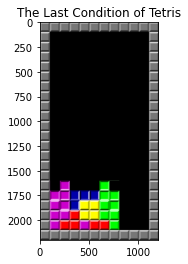

In [16]:
plt.title('The Last Condition of Tetris')
plt.imshow(tetris)
plt.show()